# 1 **引言**
---
本文一些思路来自东方证券的《因子选股系列研究之二十一——组合优化是与非》。在该文中，作者介绍了很多组合优化的求解方法，让人获益匪浅。
在魏老师的帖子[风险模型应用之归因分析：以“长信量化先锋混合”为例](https://uqer.io/community/share/5924264f1bfe1200587f2f07)中，魏老师介绍了如何使用优矿的风险模型进行组合的归因分析。风险模型的还有一个功能是精确并高效地对组合风险大小进行预测。假设我们用标准差（波动率）来度量风险，那么对于一个组合的风险的计算，我们需要知道每个股票自身的方差以及他们之间的相关性，一般来说，对于一个由N支股票构成的组合，我们需要估计$\frac{N(N+1)}{2}$个参数。我们经常会用一个对称的协方差矩阵$V$来表示需要估计哪些参数:
$$V=
 \left[
 \begin{matrix}
   \sigma_{1}^{2} & \sigma_{12} & ... & \sigma_{1N}\\
   \sigma_{12} & \sigma_{2}^{2} & ... & \sigma_{2N}\\
   ... & ... & ... & ...\\
   \sigma_{1N} & \sigma_{2N} & ... & \sigma_{N}^{2}\\
  \end{matrix}
  \right]
$$
我们将$r_{i}$和$r_{j}$之间的协方差表示为$\sigma_{ij}$，显然$\sigma_{ij}=\sigma_{ji}$。这个协方差矩阵记录了计算组合风险所需要的所有信息，但是它本身又包含了大量独立的参数，所以估计起来极具挑战性。这些问题，东方证券的《A股市场分析》也有说明，他们使用了压缩估计的方法，后面我也会对压缩矩阵，和优矿的风险模型两个方法进行比较。

# **2 协方差矩阵的估计**
---
## 2.1 单因子模型
单因子模型的基本思路是：证券收益只受一个因素影响。市场模型便是这种模型的典型例子。如果我们观察证券市场，就会发现，当市场股价指数上涨时，大部分股票价格也同时上涨；反之亦然。这说明，各种证券对一个因子，即市场股价指数的变化具有联动的反应。基本公式为：$$r_{j}=\alpha_{j}+\beta_{j}F+\epsilon_{j}$$
其中，$F$是共同因子的预测值，$\beta_{j}$为证券j对因子的灵敏度。$\epsilon_{j}$是一个随机误差项，其预期值为零，标准差为$\sigma_{\epsilon_{j}}$。单因子模型假设残差收益率$\epsilon_{j}$是互不相关的，于是：
$$cov(r_{i}, r_{j})=\beta_{i}\beta_{j}\sigma_{F}^{2}$$
$$\sigma_{j}^{2}=\beta_{j}^{2}\sigma_{F}^{2}+\sigma_{\epsilon_{j}}^{2}$$
## 2.2 基于历史数据的模型
这种方法就非常简单粗暴了，可以发现社区相关的帖子都是用这种方法进行估计。但是这种方法不稳健，不合理。假设我们需要用T个时期的样本来估计一个N\*N的协方差矩阵，那么一个最基本的要求就是T>N，否则，估计出来的协方差矩阵不可逆。如果我们要估计沪深300指数成分股月度收益率的协方差矩阵，我们至少需要25年的数据，于是东方证券的压缩估计说的就是这个事。当然，很多人不用这个方法还有其他的原因，比如，为了使得T>N，我们不得不使用更加高频的数据，比如周度数据，或者日度数据，但问题在于，我们需要预测的可能是一个月度甚至更加低频的数据，有的人是直接采用类似于年化的方法给它乘一个系数。又比如实证发现如果用历史收益率的均值和样本协方差作为预期收益率和协方差矩阵的估计去做均值方差优化，得到的最优组合里资产的权重并不分散，会有非常大的多头权重和空头权重集中在个别资产上。而且小幅变动单个资产的预期收益率数值将导致整个组合权重的大幅变动（Chopra (1993) & Kolusheva(2007)），这样的组合在实际投资中几乎没有使用价值。 
## 2.3 结构化风险模型
我们主要介绍的是结构化风险模型。股票的收益率可以归结为由一些影响所有股票的共同因子和仅与该支股票相关的特异因子所解释。更具体的说：
$$r_{n}=\sum_{k}X_{nk}f_{k}+u_{n}$$
更一般地：
$$R=XF+u$$
其中：$X_{nk}$表示第n只股票在因子k上的暴露，$f_{k}$表示因子收益率，$u_{n}$表示第n支股票的特质收益率，而$R$则表示收益率构成的向量，$X$是因子暴露矩阵。我们从上式中便得到了组合股票之间的协方差矩阵为：
$$V=X\Sigma X'+\Delta$$
组合的标准差即为：
$$\sigma_{p}=\sqrt{\omega'(X\Sigma X'+\Delta)\omega}$$
式中，$\Sigma$表示k\*K的因子收益率协方差矩阵，$\omega$表示股票权重向量，$\Delta$表示n\*n的特质收益率协方差矩阵，我们假设任意两支股票之间的特质收益率之间互不相关，所以这是一个对角矩阵，同时我们假设特质收益率与因子收益率之间也互不相关。因子收益率我们可以通过回归获得，注意这是一个横截面的多元回归，当然也不是就做个简单的线性回归，还有很多细节的地方要处理，反正Barra卖的那么贵总是有理由的，有些处理方法他们也不说。优矿的大大们已经把这些工作全都做好了，提供了下面9个风险模型的接口供使用：
1. 因子暴露数据 `DataAPI.RMExposureDayGet`
2. 因子收益数据 `DataAPI.RMFactorRetDayGet`
3. 特质收益数据 `DataAPI.RMSpecificRetDayGet`
4. 风险因子协方差矩阵表(日级别) `DataAPI.RMCovarianceDayGet`
5. 风险因子协方差矩阵表(short类型) `DataAPI.RMCovarianceShortGet`
6. 风险因子协方差矩阵表(long类型) `DataAPI.RMCovarianceLongGet`
7. 特质风险表(day类型) `DataAPI.RMSriskDayGet`
8. 特质风险表(short类型) `DataAPI.RMSriskShortGet`
9. 特质风险表(long类型) `DataAPI.RMSriskLongGet`

那风险模型强大在哪呢：前面我们说了，对于一个由N支股票构成的组合，我们需要估计$\frac{N(N+1)}{2}$个参数，那么假设我们现在有2000支股票的协方差矩阵，这意味着我们需要估计2001000个独立的参数，如果我们真的那么天真的按照历史收益率数据一个个去计算，得到的协方差矩阵也是非常病态的，很容易受到噪声的影响。那我们再看结构化风险模型需要估计多少个参数，优矿选择了39个风险因子，所以因子收益率协方差矩阵需要估计的参数才780个，大大的降低了估计的难度。

# **3 组合构建常用方法**
---
## 3.1 经验方法
一种常见的方法是让组合的行业权重与基准的行业权重一致（主动行业暴露为0）。然后在行业内选择因子得分最大的前x%的股票，再把行业的权重等额的分配到这些行业上。但是这种方法没有控制某些组合在风险因子上的暴露，例如市值因子，组合面临的风险较强。一种方法是在行业内将股票按市值分档，然后在每档里面取前y%支股票。但是这种控制方法并不精确。
## 3.2 组合优化的方法
投资者在进行量化对冲，指数增强时，往往会控制组合的风险暴露，我么可以用下面mean-variance问题来进行描述:
$$max:\omega'\alpha-\frac{\lambda}{2}\omega'\Sigma\omega$$
$$st:min\\_weight<=\omega_{i,t}<=max\\_weight$$
$$\sum_{k}\omega_{i,t}=1$$
$$\sum_{k}|\omega_{i,t}-\omega_{i, t-1}| <= turnover\\_target$$
$$X(\omega-\omega_{benchmark})=0$$
上面的公式给了四个约束：
* `个股权重约束`:这是一个很明显的约束，因为A股市场不允许做空，所以我们个股的权重必须要控制在0到1之间。
* `权重之和约束`:我们假设组合所有股票权重之和为1，也就是满仓
* `换手率约束`:我们对换手率进行控制，换手率的计算公式为：$\sum_{k}|\omega_{i,t}-\omega_{i, t-1}|$，注意这个约束带绝对值，求解起来要用特殊的方法。
* `风险因子约束`：我们要控制组合在某个风险因子上的暴露

当然，还可以添加其他的约束，但本文主要就考虑了这些。
那组合优化的意义在于哪呢，其实组合优化的目的在于对投资组合进行精确的控制，包括组合风险暴露、换手率、个股权重上下限、跟踪误差等，降低策略收益的不确定性，但并不一定能提高组合的业绩表现。
`两点说明：`
1. 通过风险因子矩阵X可以得到股票之间的协方差矩阵。
2. 股票的alpha的估计可以使用回归的方法。本文目前只考虑线性规划，所以忽略了二次项，目标函数为最大化组合的Alpha，假设股票的收益率与因子的zscore得分是个线性的关系，因此目标函数直接可以写成最大化股票的zscore得分。当然，正确的做法是要将把多因子得分转换成个股预测收益率，需要做横截面回归。

# **4 数据准备**
---
我们基于估值，盈利，成长，波动这四类因子，来做中证500指数增强组合。因子具体如下：
* 估值：
	* BP：市净率倒数
	* EP：市盈率倒数
	* SP：市销率倒数
	* CFP：市现率倒数
	* EBIT：息税前利润
	* RevenueTTM：营业收入
* 盈利：
	* ROA：总资产收益率
	* ROE：净资产收益率
	* GrossIncomeRatio：销售毛利率
	* OperatingProfitRatio_pure：净利润率
* 成长：
	* OperatingRevenueGrowRate：营业收入对比
	* NetProfitGrowRate：净利润增长率
	* NetAssetGrowRate：净资产增长率
* 波动：
	* realizedVolatility_3M：过去三个月日收益率数据计算的标准差
	* maxRet：上月最大日收益

回测区间为2009年1月31日到2017年8月31日。实际操作过程中，我们还添加了跟踪误差约束，使得跟踪误差不超过5%，个股上限不超过1%，行业与市值中性。

In [ ]:
#-*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import talib as ta
import seaborn as sns
import time
import statsmodels.api as sm

from sklearn.covariance import LedoitWolf
from scipy.stats import mstats
from scipy import stats
from datetime import datetime, timedelta
from matplotlib.pylab import *
from sklearn.linear_model import LinearRegression
from quartz_extensions.Optimizer import *
from CAL.PyCAL import *
sns.set_style('white')
cal = Calendar('China.SSE')

In [ ]:
def plot_under_water(bt, ylim1=(0.9, 4), ylim2=(-0.2, 0)):
    bt1 = bt
    bt_quantile_ten = bt1
    data = bt_quantile_ten[[u'tradeDate',u'portfolio_value',u'benchmark_return']]
    data['portfolio_return'] = data.portfolio_value/data.portfolio_value.shift(1) - 1.0
    data['portfolio_return'].ix[0] = data['portfolio_value'].ix[0]/	10000000.0 - 1.0
    data['excess_return'] = data.portfolio_return - data.benchmark_return
    data['excess'] = data.excess_return + 1.0
    data['excess'] = data.excess.cumprod()

    df_cum_rets = data['excess']
    running_max = np.maximum.accumulate(df_cum_rets)
    underwater = -((running_max - df_cum_rets) / running_max)
    underwater.index = data['tradeDate']

    fig = plt.figure(figsize=(12, 5))
    fig.set_tight_layout(True)
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    x = range(len(underwater))
    ax1.grid(True)
    ax1.set_ylim(ylim2[0], ylim2[1])
    ax1.fill_between(underwater.index, 0, np.array(underwater), color='#000066', alpha=1)

    ax2.plot(data['tradeDate'], data[['excess']], label='hedged(right)', color='r')
    ax2.set_ylim(bottom=ylim1[0], top=ylim1[1])
    s = ax1.set_title(u"股票月度调仓走势", fontproperties=font, fontsize=16)
    return fig

# **5 经验方法回测**

In [ ]:
factor = pd.read_csv('four_kind_factor.csv', index_col=0)

In [ ]:
bt1 = bt

# **6. 组合优化**
---
## 6.1 模型建立
因为风险模型获取协方差矩阵权限的原因，我把目标函数的二次项取消了，也就是$\lambda=0$的情况。我们的模型如下：
$$max:\omega'\alpha$$
$$st:0<=\omega_{i,t}<=0.01$$
$$\sum_{k}\omega_{i,t}=1$$
$$IE(\omega-\omega_{benchmark})=0$$
$$MCE(\omega-\omega_{benchmark}) = 0$$
$$\omega_{active}'\Sigma\omega_{active} <= 0.5$$
本文限制了组合个股最大权重为0.005，主动行业暴露为0，主动市值暴露为0，满仓操作。
其中，IE表示行业矩阵，MCE表示市值向量。

In [ ]:
weights = pd.DataFrame()
date_list = []
for date in factor_data.index:
    signal = factor_data.loc[date, set_universe('ZZ500', ''.join(date.split('-')))].dropna()
    pspec = UqerOptimizer(signal, ''.join(date.split('-')))
    pspec.add_constraint('limit_weight', default_min_weight=0., default_max_weight=0.01)
    pspec.add_constraint('indu')
    pspec.add_constraint('style', spec_style={'SIZE':ut.get_benchmark_style_exposure('ZZ500', 'SIZE', ''.join(date.split('-')))})
    pspec.add_constraint('tracking_error', 0.0025)
    pspec.solve()
    if pspec.optimal == False:
        print date
    else:
        weights = weights.append(pspec.assets.optimal_weights)
        date_list.append(date)

In [ ]:
bt2 = bt

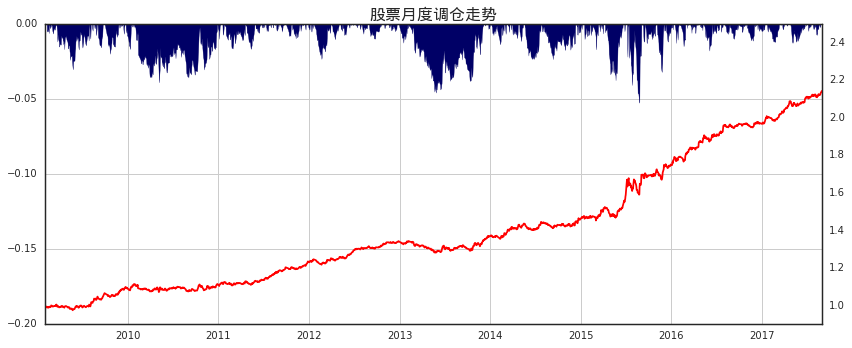

In [ ]:
fig1 = plot_under_water(bt1, ylim1=(0.9, 2.5), ylim2=(-0.2, 0))

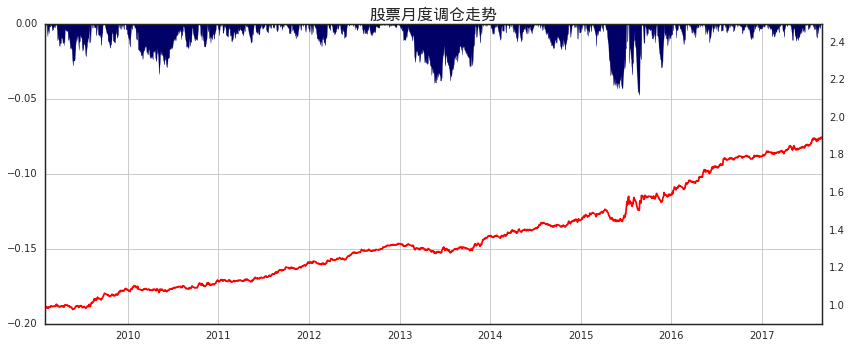

In [ ]:
fig2 = plot_under_water(bt2, ylim1=(0.9, 2.5), ylim2=(-0.2, 0))

# **7. 总结**
* 本文主要通过优化器来控制组合的行业和市值这两个风险因子的暴露，没有去控制换手率。我们还可以对其他风险因子进行控制，例如波动率，动量，Beta等等。
* 我们可以具体来看看组合的市值是否和基准走势一致（其实也没有必要比较，优化器如果有解，那么一定是符合约束的）。
* 从净值曲线上来看，虽然通过组合优化的方法，损失了一部分收益，但是我们却很好的控制了组合的波动。
* 我们可以进一步的通过对市场风格的判断，来控制组合在某一风格上的暴露，从而增加收益。